In [21]:
%matplotlib inline

In [22]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling


In [23]:
os.chdir('AnomaliesRecycling')
print("Current working directory: {0}".format(os.getcwd()))

FileNotFoundError: [Errno 2] No such file or directory: 'AnomaliesRecycling'


Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [25]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from transfer_learning import create_image_datasets, create_dataloaders, train_model, visualize_model, print_missclassified, print_confusion_matrix, imshow


plt.ion()   # interactive mode

In [26]:
torch.cuda.is_available()
#torch.cuda.current_device()

True

Load Data and Data Augmentation
---------

In [39]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),

        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [40]:
batch_size = 32
data_dir = 'data'
image_datasets, class_names = create_image_datasets()
dataloaders = create_dataloaders(image_datasets, batch_size=batch_size)

Visualize a few images



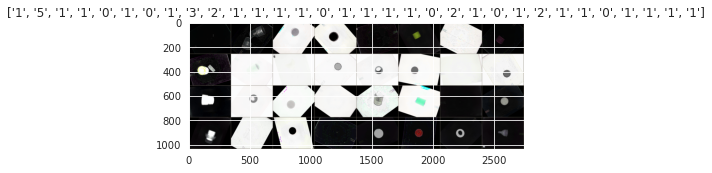

In [41]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [44]:
model_name = "GoogleNet"
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, 6)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

 ***Train and evaluate***

In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, image_datasets, num_epochs=50, model_name=model_name)

Epoch 0/49
----------


/home/p22g5/anaconda3/envs/recycling/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.9916 Acc: 0.6482
test Loss: 0.7830 Acc: 0.6642

Epoch 1/49
----------
train Loss: 0.6934 Acc: 0.7541
test Loss: 0.5487 Acc: 0.8167

Epoch 2/49
----------
train Loss: 0.5354 Acc: 0.8005
test Loss: 0.4804 Acc: 0.8494

Epoch 3/49
----------
train Loss: 0.4672 Acc: 0.8391
test Loss: 0.4113 Acc: 0.8530

Epoch 4/49
----------
train Loss: 0.3941 Acc: 0.8705
test Loss: 0.3732 Acc: 0.8784

Epoch 5/49
----------
train Loss: 0.3779 Acc: 0.8682
test Loss: 0.3470 Acc: 0.8820

Epoch 6/49
----------
train Loss: 0.3480 Acc: 0.8773
test Loss: 0.3312 Acc: 0.8838

Epoch 7/49
----------
train Loss: 0.3372 Acc: 0.8805
test Loss: 0.3222 Acc: 0.8947

Epoch 8/49
----------
train Loss: 0.3191 Acc: 0.8832
test Loss: 0.3158 Acc: 0.8947

Epoch 9/49
----------
train Loss: 0.3082 Acc: 0.8932
test Loss: 0.3095 Acc: 0.9020

Epoch 10/49
----------
train Loss: 0.3036 Acc: 0.8923
test Loss: 0.2878 Acc: 0.8929

Epoch 11/49
----------
train Loss: 0.2775 Acc: 0.8982
test Loss: 0.3012 Acc: 0.8838

Epoch 12/49


In [47]:
from torchray.attribution.grad_cam import grad_cam
from torchray.benchmark import get_example_data, plot_example

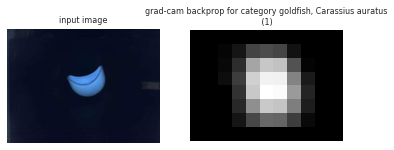

In [65]:
model_name = "ResNet18"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft.load_state_dict(torch.load("./models/"+model_name))
#print(model_ft)
# Obtain example data.
i = 100
model, x, category_id = model_ft, image_datasets['test'][i][0].unsqueeze(0),image_datasets['test'][i][1]
# Grad-CAM backprop.
saliency = grad_cam(model, x, category_id, saliency_layer='layer4.1.conv2')

# Plots.
plot_example(x, saliency, 'grad-cam backprop', category_id)

In [5]:
!reload_ext tensorboard
!tensorboard --logdir runs

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: reload_ext: command not found
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


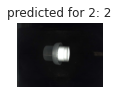

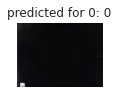

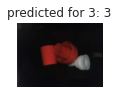

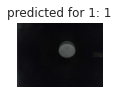

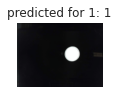

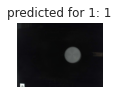

In [35]:
model_name = "ResNet18"
model_ft.load_state_dict(torch.load("./models/"+model_name))
visualize_model(model_ft, dataloaders, class_names)

***Filenames where validation failed***

In [36]:
print_missclassified(model_ft, image_datasets)

('data/test/0/Anlerndaten (622).jpg', 0)
must be 0, but predicted 1
('data/test/1/Anlerndaten (14).jpg', 1)
must be 1, but predicted 2
('data/test/1/Anlerndaten (804).jpg', 1)
must be 1, but predicted 2
('data/test/1/Anlerndaten (931).jpg', 1)
must be 1, but predicted 2
('data/test/2/Anlerndaten (255).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (423).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (596).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (615).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (669).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (980).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1013).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1018).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1326).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1371).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (611).jpg', 2)
must be 2, but predicted 1
('data/

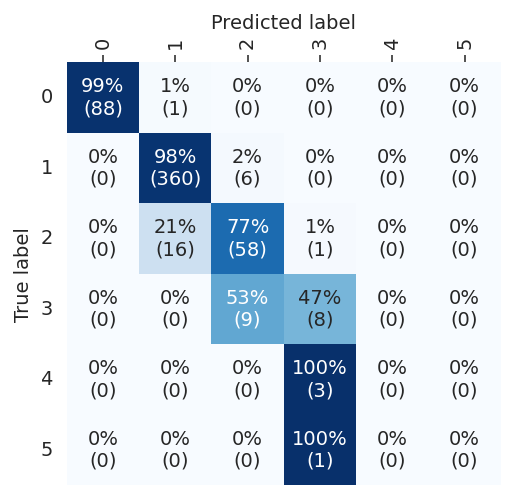

In [46]:
print_confusion_matrix(model_ft, dataloaders, class_names)

ConvNet as fixed feature extractor
----------------------------------

In [79]:
model_name = "ResNet18_freezed"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [81]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders, image_datasets,  num_epochs=50, model_name=model_name)

Epoch 0/49
----------
train Loss: 0.8307 Acc: 0.6977
test Loss: 0.5755 Acc: 0.7786

Epoch 1/49
----------
train Loss: 0.7038 Acc: 0.7482
test Loss: 0.8494 Acc: 0.6987

Epoch 2/49
----------
train Loss: 0.6470 Acc: 0.7691
test Loss: 0.4865 Acc: 0.8221

Epoch 3/49
----------
train Loss: 0.5775 Acc: 0.7886
test Loss: 0.4508 Acc: 0.8530

Epoch 4/49
----------
train Loss: 0.5704 Acc: 0.7818
test Loss: 0.6314 Acc: 0.7387

Epoch 5/49
----------
train Loss: 0.5340 Acc: 0.7982
test Loss: 0.4207 Acc: 0.8603

Epoch 6/49
----------
train Loss: 0.5195 Acc: 0.8041
test Loss: 0.4809 Acc: 0.8566

Epoch 7/49
----------
train Loss: 0.4549 Acc: 0.8300
test Loss: 0.4015 Acc: 0.8584

Epoch 8/49
----------
train Loss: 0.4685 Acc: 0.8314
test Loss: 0.3961 Acc: 0.8566

Epoch 9/49
----------
train Loss: 0.4585 Acc: 0.8350
test Loss: 0.4070 Acc: 0.8512

Epoch 10/49
----------
train Loss: 0.4460 Acc: 0.8364
test Loss: 0.4058 Acc: 0.8566

Epoch 11/49
----------
train Loss: 0.4324 Acc: 0.8482
test Loss: 0.3950 Acc

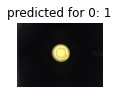

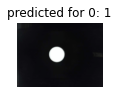

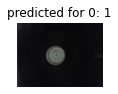

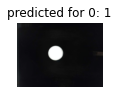

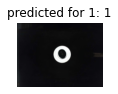

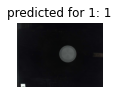

In [82]:
visualize_model(model_conv)